In [1]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from rasterio.plot import reshape_as_raster, reshape_as_image
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import jaccard_score

ModuleNotFoundError: No module named 'rasterio'

## Loading Data

In [2]:
nm_shp = gpd.read_file("JamaicaNonmangroveLabels.shp")
m_shp = gpd.read_file("JamaicaMangroveLabelsFixed.shp")

nm_geoms = nm_shp.geometry
m_geoms = m_shp.geometry

In [3]:
src = rasterio.open("JamaicaFeaturesNoSAR.tif")
mask_src = rasterio.open("JamaicaImageMask.tif")
m_image, m_transform = mask(src, m_geoms, crop=True)
nm_image, nm_transform = mask(src, nm_geoms, crop=True)

#Getting mask for each class
mmask, mmask_transform = mask(mask_src, m_geoms, crop=True)
nmmask, nmmask_transform = mask(mask_src, nm_geoms, crop=True)

In [4]:
m_image.shape

(9, 3101, 4213)

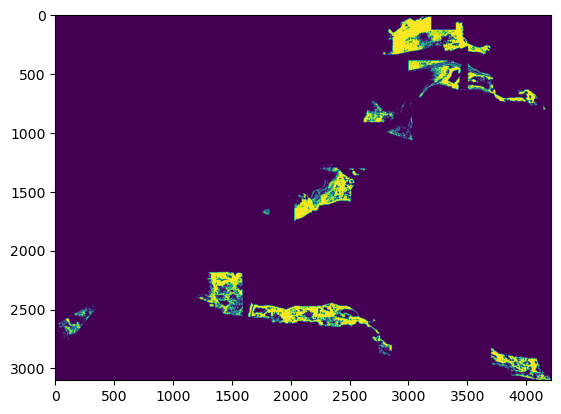

<AxesSubplot:>

In [5]:
from rasterio.plot import show
show(mmask)

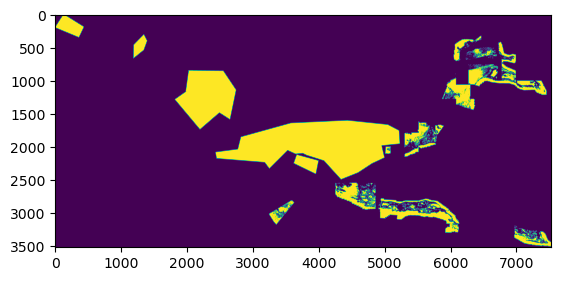

<AxesSubplot:>

In [6]:
show(nmmask)

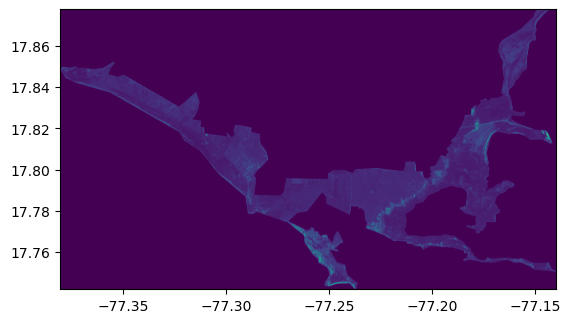

<AxesSubplot:>

In [7]:
show(src)

# Reshaping Data

In [8]:
m_idx = np.squeeze(((reshape_as_image(mmask) == 1)), axis=-1)
nm_idx = np.squeeze((reshape_as_image(nmmask) == 1), axis=-1)

In [9]:
m_pix = reshape_as_image(m_image)[m_idx]
nm_pix = reshape_as_image(nm_image)[nm_idx]

m_pix = m_pix[np.all(m_pix != 0, axis=1)]
nm_pix = nm_pix[np.all(nm_pix != 0, axis=1)]

In [10]:
x = np.concatenate((m_pix, nm_pix), axis = 0)
y = np.concatenate((np.zeros((m_pix.shape[0]))+1, np.zeros((nm_pix.shape[0]))))

# Extremely Randomized Trees 

In [11]:
from sklearn.metrics import make_scorer
iou = make_scorer(jaccard_score, average ='weighted')

In [12]:
clf = ExtraTreesClassifier(n_jobs=4)
scores = cross_val_score(clf, x, y, cv=5)

In [13]:
scores_iou = cross_val_score(clf, x, y, scoring = iou, cv=5)

In [14]:
print("%0.2f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))
print("%0.2f accuracy with a standard deviation of %0.3f" % (scores_iou.mean(), scores_iou.std()))

0.92 accuracy with a standard deviation of 0.047
0.87 accuracy with a standard deviation of 0.063


# LightGBM Training

In [15]:
import lightgbm as lgb

ModuleNotFoundError: No module named 'lightgbm'

In [ ]:
import lightgbm as lgb

d_train = lgb.Dataset(x_train, label=y_train)

In [ ]:
params={}
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='binary' #Multi-class target feature
params['metric']='auc' #metric for multi-class

gbm = lgb.train(params, d_train, 100)
scores = cross_val_score(gbm, x, y, cv=5)
scores_iou = cross_val_score(svm, x, y, scoring = iou, cv=5)

In [ ]:
print("%0.2f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))
print("%0.2f accuracy with a standard deviation of %0.3f" % (scores_iou.mean(), scores_iou.std()))

# Model Performance - MLP

In [16]:
from sklearn.neural_network import MLPClassifier


mlp = MLPClassifier()
scores = cross_val_score(mlp, x, y, cv=5)
scores_iou = cross_val_score(mlp, x, y, scoring = iou, cv=5)

In [17]:
print("%0.2f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))
print("%0.2f accuracy with a standard deviation of %0.3f" % (scores_iou.mean(), scores_iou.std()))

0.93 accuracy with a standard deviation of 0.038
0.87 accuracy with a standard deviation of 0.066


# Model Performance - Decision Trees

In [18]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
scores = cross_val_score(dt, x, y, cv=5)
scores_iou = cross_val_score(dt, x, y, scoring = iou, cv=5)

In [19]:
print("%0.2f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))
print("%0.2f accuracy with a standard deviation of %0.3f" % (scores_iou.mean(), scores_iou.std()))

0.90 accuracy with a standard deviation of 0.053
0.83 accuracy with a standard deviation of 0.068


In [20]:
from sklearn.ensemble import GradientBoostingClassifier

gbt = GradientBoostingClassifier()
scores = cross_val_score(gbt, x, y, cv=5)
scores_iou = cross_val_score(gbt, x, y, scoring = iou, cv=5)

In [22]:
print("%0.2f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))
print("%0.2f accuracy with a standard deviation of %0.3f" % (scores_iou.mean(), scores_iou.std()))

0.92 accuracy with a standard deviation of 0.049
0.86 accuracy with a standard deviation of 0.065


In [23]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
scores = cross_val_score(rf, x, y, cv=5)
scores_iou = cross_val_score(rf, x, y, scoring = iou, cv=5)

In [24]:
print("%0.2f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))
print("%0.2f accuracy with a standard deviation of %0.3f" % (scores_iou.mean(), scores_iou.std()))

0.92 accuracy with a standard deviation of 0.049
0.86 accuracy with a standard deviation of 0.065
